# Import preamble

In [363]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
# from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

from xgboost import XGBClassifier

rs = 42

from pprint import pprint
# from IPython.core.debugger import Tracer

In [499]:
# Get confusion matrix
def cm(model, X_test, y_test, threshold=0.5):
    probs = model.predict_proba(X_test)
    over = probs[:,1]>threshold
#     y_pred = model.predict(X_test)
#     cm_ = confusion_matrix(y_test, y_pred)
    cm_ = confusion_matrix(y_test, list(map(lambda x: 1 if x else 0, over)))
    return pd.DataFrame(cm_, columns=['pred_0', 'pred_1'])

def get_weights(y):
    temp = y.value_counts(normalize=True)
    weights = [1.0/temp[i] for i in y]
    return weights

def get_class_weights(y):
    temp = y.value_counts(normalize=True)
    return temp.map(lambda x: 1.0/x)

def plot_roc(modelstrings):
    models = dict((name, eval(name)) for name in modelstrings)
    auc_scores = []

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.set_aspect('equal')
    ax1.set_xlabel('False positives')
    ax1.set_ylabel('True positives')
    for model in models.keys():
        y_score = models[model].predict_proba(test[predictors])[:,1]

        fpr, tpr, _ = roc_curve(test['Class'], y_score)
        auc_scores.append(roc_auc_score(test['Class'], y_score))

        ax1.plot(fpr, tpr, label=model)
    ax1.legend(loc=4)

    YX=list(zip(auc_scores, models.keys()))
    YX.sort()
    Y, X = zip(*YX)
    ax2.plot(range(len(X)), Y)
    ax2.set_ylabel('AUC')
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels(X)
    plt.setp(ax2.get_xticklabels(), rotation=45)

def plot3(models, test):
    '''
    Plot ROC curve, AUC of the ROC curve, and the precision-recall curve for given models.
    Models should be an array of dicts with the following fields
    '''
    auc_scores = []
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    ax1.set_aspect('equal')  
    ax1.set_xlabel('False positives')
    ax1.set_ylabel('True positives')
    ax2.set_ylabel('AUC')
    ax3.set_aspect('equal')  
    ax3.set_xlabel('Precision')
    ax3.set_ylabel('Recall')
    for model in models:
        y_score = model['estimator'].predict_proba(test[model['predictors']])[:,1]
        fpr, tpr, _ = roc_curve(test['Class'], y_score)
        precision, recall, _ = precision_recall_curve(test['Class'], y_score)
        auc_scores.append(roc_auc_score(test['Class'], y_score))
        ax1.plot(fpr, tpr, label=model['name'])
        ax3.plot(precision, recall, label=model['name'])
    ax1.legend(loc=4)
    ax3.legend(loc=0)

    YX=list(zip(auc_scores, list(map(lambda x: x['name'], models))))
    YX.sort()
    Y, X = zip(*YX)
    ax2.plot(range(len(X)), Y)
    ax2.set_ylabel('AUC')
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels(X)
    plt.setp(ax2.get_xticklabels(), rotation=45)
 
def GridSearchWrapper(model, param_grid, X_train, y_train, cv=None, refit=True, log=False, fit_params=None):
    
    gs = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', refit=refit, n_jobs=-1, 
                      fit_params=fit_params)
    gs.fit(X_train, y_train)
    
    if len(param_grid) == 1:
        if log:
            plt.semilogx(list(param_grid.values())[0], gs.cv_results_['mean_test_score'])
        else:
            plt.plot(list(param_grid.values())[0], gs.cv_results_['mean_test_score'])
        plt.gca().set_xlabel(list(param_grid.keys())[0])
        plt.gca().set_ylabel('AUC')
        plt.show()
    else:
        print('sweep plot only implemented for one parameter')
        
    return gs


def plot_xgb_epochs(model, ylim=None):
    results = model.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)
    plt.figure()
    ax=plt.gca()
    if len(results) == 1:
        ax.plot(x_axis, results['validation_0']['auc'], label='Test')
    if len(results) == 2:
        ax.plot(x_axis, results['validation_0']['auc'], label='Train')
        ax.plot(x_axis, results['validation_1']['auc'], label='Test')
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Score')
    ax.legend()
        
        
def auc_score(model, X, y):
    y_score = model.predict_proba(X)[:,1]
    return roc_auc_score(y, y_score)

### Import data

In [365]:
df = pd.read_csv("data/creditcard.csv")
# If running as Kaggle kernel, import from their server:
# df = pd.read_csv("../input/creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory data analysis

You can see above that there are numerous predictor variables labelled V1-V28. These are anonymised variables produced from raw data using PCA. 

### Class imbalance

We are aiming to predict the variable 'Class', where 0 corresponds to a normal transaction and 1 corresponds to a fraudulent one. As expected, the classes are highly imbalanced, with fraudulent cases about 0.17%. 

In [323]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

### Time variable
The Time variable measures seconds from first transaction in the dataset, and the data spans two days, $2\times86400 = 172800$ seconds. 

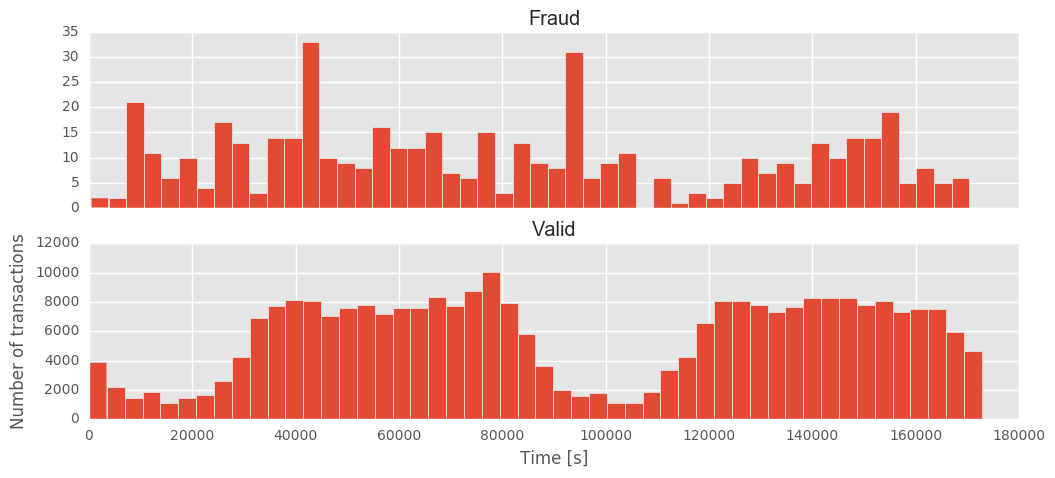

In [366]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,5))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Valid')

plt.xlabel('Time [s]')
plt.ylabel('Number of transactions')
plt.show()

The dependence on time is expectedly cyclical and we can turn the Time variable into 'Time of day' and 'Day', where 'Time of day' is expected to have a higher correlation with 'Class' and certainly be more generalisable, unless we could find out what day of the week it is. 

In [367]:
df['TOD'] = df['Time']%86400
df['Day'] = df['Time']//86400

Let's also scale the variables that are on very different scales than the V1-V28 variables:

In [368]:
# Put 'Amount' on a similar scale as the predictor variables
df['Amount_scaled'] = df['Amount']/np.std(df['Amount'])
# And also TOD
df['TOD_scaled'] = df['TOD']/86400

# Split off test dataset

In [369]:

train, test = train_test_split(df, test_size=0.25, stratify=df['Class'], random_state=rs)


# Train models

This is a highly imbalanced dataset, with fraud classifications only a fraction of a percent of the total. This needs to be adjusted for in some way, and can be done by manually oversampling, undersampling or supplying weights to the model. 

In [370]:
# Define an array of the predictor variables that we are going to consider in our models
predictors = ['TOD_scaled', 'Day', 'Amount_scaled', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

### Logistic regression

Let's start off with logistic regression. First we train with the original imbalanced dataset.

In [371]:
logistic_imbalanced = LogisticRegression(random_state=rs)
logistic_imbalanced.fit(train[predictors], train['Class'])

cm(logistic_imbalanced, test[predictors], test['Class'])

,pred_0,pred_1
0,71065,14
1,45,78


Let's now try using the 'sample_weight' option when fitting. It weights each datapoint by the inverse of the fraction of the corresponding class in the dataset

In [372]:
logistic_weighted = LogisticRegression(random_state=rs, class_weight = dict(get_class_weights(train['Class'])))
logistic_weighted.fit(train[predictors], train['Class'])

cm(logistic_weighted, test[predictors], test['Class'])

,pred_0,pred_1
0,69395,1684
1,14,109


Undersampling is done simply by combining all data with class '0' with an equal number of randomly selected points from class '1'. 

In [373]:
train_0 = train[train['Class']==0]
train_1 = train[train['Class']==1]
train_0 = train_0.sample(len(train_1), random_state=rs)

train_under = pd.concat([train_0, train_1])

logistic_under = LogisticRegression(random_state=rs)
logistic_under.fit(train_under[predictors], train_under['Class'])

cm(logistic_under, test[predictors], test['Class'])

,pred_0,pred_1
0,68420,2659
1,13,110


Oversampling is done by taking a random sample with replacement from class '1' data, of size equal to the class '0' data. 

In [374]:
train_0 = train[train['Class']==0]
train_1 = train[train['Class']==1]
train_1 = train_1.sample(len(train_0), replace=True, random_state=rs)
train_over = pd.concat([train_0, train_1])

logistic_over = LogisticRegression(random_state=rs)
logistic_over.fit(train_over[predictors], train_over['Class'])

cm(logistic_over, test[predictors], test['Class'])

,pred_0,pred_1
0,69405,1674
1,14,109


### Parameter tuning

Optimising model performance usually means tuning the model parameters. For logistic regression the parameter to tune is the regularisation strength.

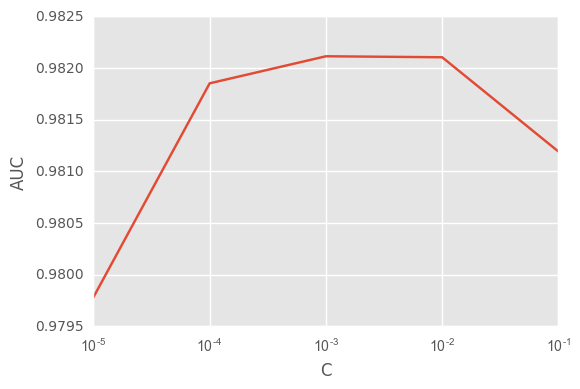

In [392]:
logistic_regularised = LogisticRegression(random_state=rs, class_weight = dict(get_class_weights(train['Class'])))
parameters = {'C': np.logspace(-5, -1, 5)}

# train_test_iterator = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=rs)
train_test_iterator = StratifiedKFold(n_splits=5, random_state=rs)

output = GridSearchWrapper(logistic_regularised, parameters, train[predictors], train['Class'], 
                           cv=train_test_iterator, log=True)



In [400]:
logistic_regularised = LogisticRegression(C=0.01, random_state=rs, class_weight = dict(get_class_weights(train['Class'])))
logistic_regularised.fit(train[predictors], train['Class'])

cm(logistic_regularised, test[predictors], test['Class'])

,pred_0,pred_1
0,69464,1615
1,14,109


### Compare ROCs for the different logistic models

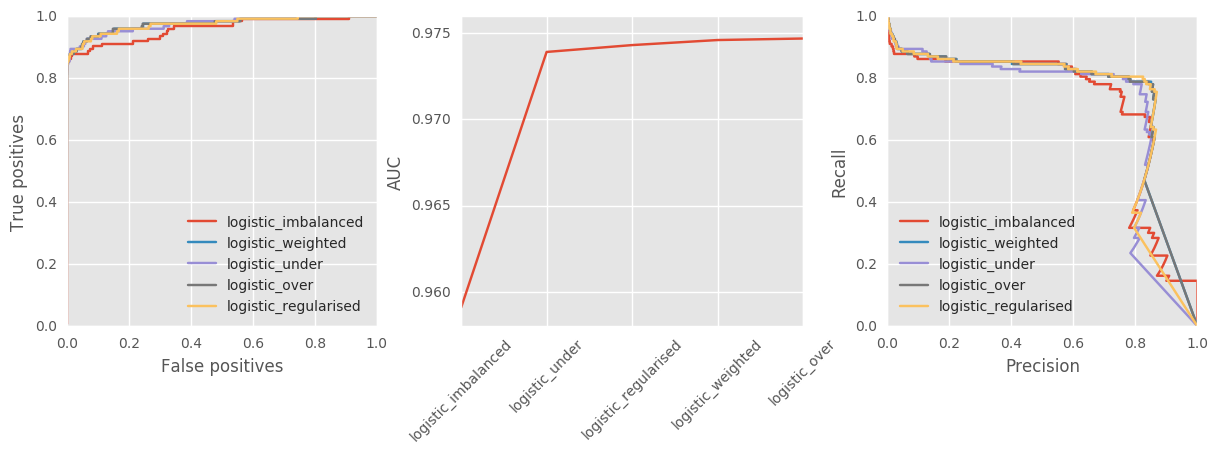

In [401]:
modelstrings=['logistic_imbalanced', 'logistic_weighted', 'logistic_under', 'logistic_over', 'logistic_regularised']
models = list(map(lambda x: {'estimator':eval(x), 'name': x, 'predictors':predictors}, modelstrings))
plot3(models, test)


### XGBoost

XGBoost is an efficient implementation of Gradient Boosted Decision Tree. It is a powerful model but requires careful hyperparameter tuning. Gradient boosting works by sequentially fitting weak estimators to reduce error stepwise. It is good to monitor both training and test score, to avoid overfitting and stop training when test score isn't increasing anymore. 

One way to tune hyperparameters is to do it manually, sweeping well chosen ranges of parameters and choosing the ones yielding the best results.

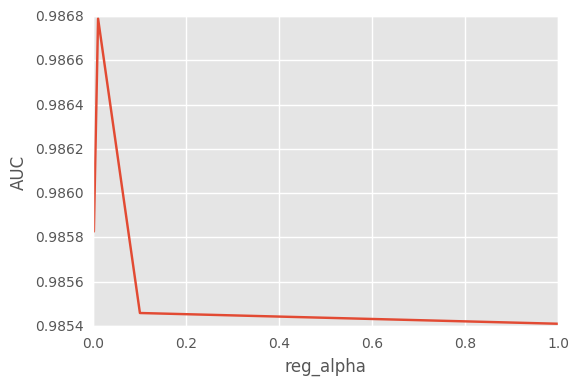

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.33,
            train_size=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=70, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6),
       fit_params={'early_stopping_rounds': 100, 'eval_set': [(        TOD_scaled  Day  Amount_scaled        V1        V2        V3  \
39041     0.459097  0.0       0.035783 -5.935256  4.952585  0.119860
205217    0.569896  1.0       0.108268  1.895331  0.508860 -0.696972
34398     0.435764  0.0     ...145, 1.001730477030145, 1.001730477030145, 1.001730477030145, 1.001730477030145, 1.001730477030145]},
       iid=True, n_jobs=-1,
       param_grid={'reg_alpha': array([  1.00000e-04,   1.00000

In [409]:

xgb = XGBClassifier(n_estimators=1000, max_depth=4, min_child_weight=70, 
                    gamma=0.2, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.001, reg_lambda=0.1, seed=rs
                   )
# xgb.fit(train[predictors], train['Class'], eval_metric='auc', sample_weight = get_weights(train['Class']))
# xgb.score(test[predictors], test['Class'], eval_metric='auc')

parameters = {'reg_alpha':np.logspace(-4, 0, 5)}

# train_test_iterator = StratifiedKFold(n_splits=3, random_state=rs)
train_test_iterator = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=rs)

GridSearchWrapper(xgb, parameters, train[predictors], train['Class'], cv=train_test_iterator, 
                  log=False, refit=False, fit_params={'sample_weight': get_weights(train['Class']),
                                                    'eval_set':[(test[predictors], test['Class'])],
                                                      'early_stopping_rounds':100, 
                                                      'verbose':False})


In [422]:
xgb = XGBClassifier(n_estimators=300, max_depth=4, min_child_weight=70, 
                    gamma=0.2, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.001, reg_lambda=0.1, seed=rs
                   )
xgb.fit(train[predictors], train['Class'], eval_metric='auc', sample_weight = get_weights(train['Class']), 
       eval_set=[(train[predictors], train['Class']),(test[predictors], test['Class'])],
          early_stopping_rounds=200, verbose=False)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=70, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0.001, reg_lambda=0.1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

Let's look at the plot of train and test score as a function of number of steps (epochs) of the XGB model.

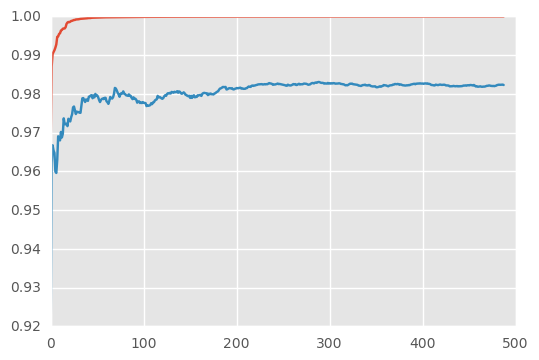

In [413]:
plot_xgb_epochs(xgb)

In [415]:
xgb.predict_proba(test[predictors])[:,1]
cm(xgb,test[predictors], test['Class'], threshold=0.5)


,pred_0,pred_1
0,71021,58
1,17,106


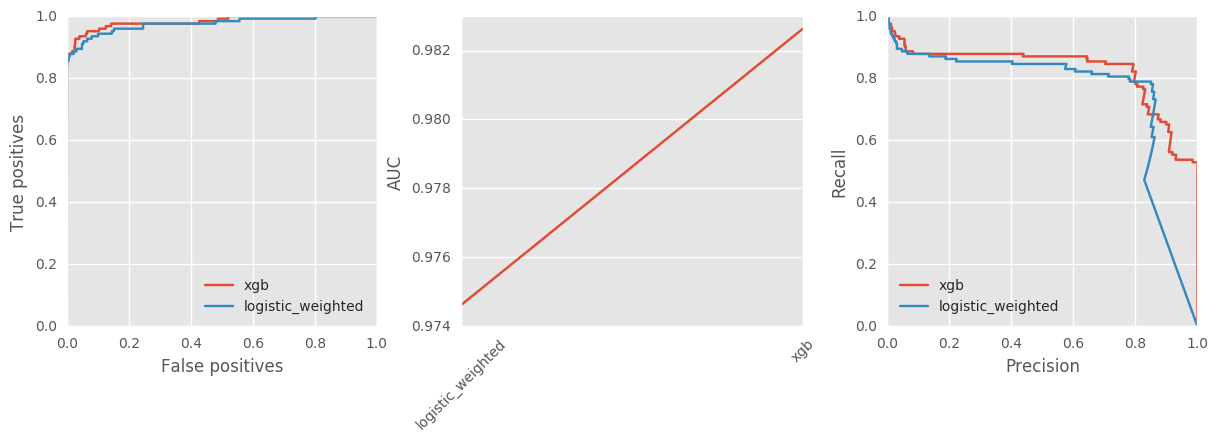

In [416]:
models = [{'name':'xgb', 'estimator': xgb, 'predictors':predictors},
         {'name':'logistic_weighted', 'estimator': logistic_weighted, 'predictors':predictors}]

plot3(models, test)

# Further improvement by feature engineering

Can we improve the results by some feature engineering?

### Comparing distributions between classes

We can look at the distribution of a predictor variable (e.g. V4) for the two different Classes. We see that the distributions are very different, and we could create a new feature p(V4|Class=1)/p(V4|Class=0) which is the ratio of the probability distributions for the two classes. Note that the ratio being larger than 1 does not mean that Class=1 is more likely than Class=0, for that to be true we would have to multiply by p(Class=1)/p(Class=0), a very small number. 

/Users/einarbui/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


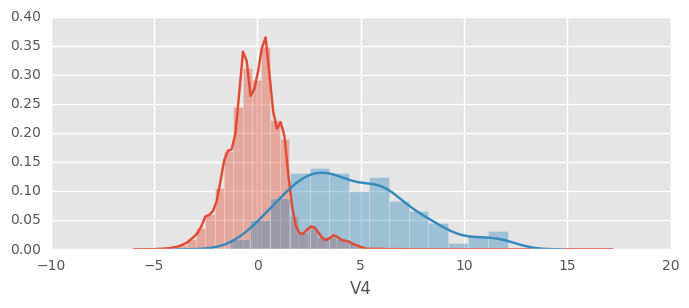

In [381]:
plt.figure(figsize=(8, 3))
sns.distplot(df['V4'][df['Class']==0])
sns.distplot(df['V4'][df['Class']==1])

Let's create variables that relate to the difference in the distributions:

In [417]:
from scipy.stats import gaussian_kde

def ratio_variable(df, variable):
    kde0 = gaussian_kde(df[variable][df['Class']==0])
    kde1 = gaussian_kde(df[variable][df['Class']==1])
    var_range = np.linspace(df[variable].min(), df[variable].max(), 100)
    k1 = kde1(var_range)
    k0 = kde0(var_range)
    ratios = (k1-k0)/(k0+k1)

    return np.interp(df[variable], var_range, ratios)
    
for i in range(1,29):
    df['V'+str(i)+'_ratio'] = ratio_variable(df, 'V'+str(i))
    


In [418]:
train, test = train_test_split(df, test_size=0.25, stratify=df['Class'], random_state=rs)

predictors2 = ['TOD_scaled', 'Day', 'Amount_scaled', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','V1_ratio',
       'V2_ratio', 'V3_ratio', 'V4_ratio', 'V5_ratio', 'V6_ratio', 'V7_ratio',
       'V8_ratio', 'V9_ratio', 'V10_ratio', 'V11_ratio', 'V12_ratio',
       'V13_ratio', 'V14_ratio', 'V15_ratio', 'V16_ratio', 'V17_ratio',
       'V18_ratio', 'V19_ratio', 'V20_ratio', 'V21_ratio', 'V22_ratio',
       'V23_ratio', 'V24_ratio', 'V25_ratio', 'V26_ratio', 'V27_ratio',
       'V28_ratio']


In [430]:

xgb2 = XGBClassifier(n_estimators=400, max_depth=4, min_child_weight=70, 
                    gamma=0.2, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.001, reg_lambda=0.1, seed=rs
                   )
xgb2.fit(train[predictors2], train['Class'], eval_metric='auc', sample_weight = get_weights(train['Class']), 
       eval_set=[(train[predictors2], train['Class']),(test[predictors2], test['Class'])],
          early_stopping_rounds=200, verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=70, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0.001, reg_lambda=0.1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

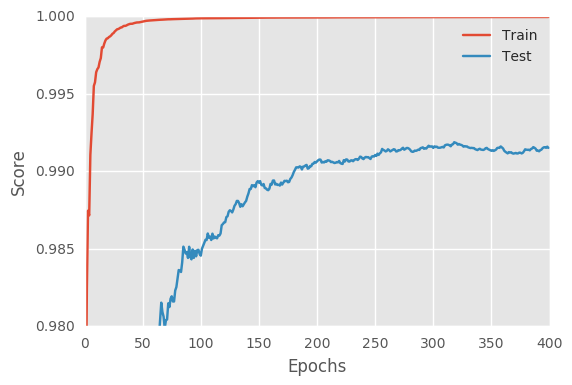

In [507]:
plot_xgb_epochs(xgb2, ylim=[0.98, 1.00])

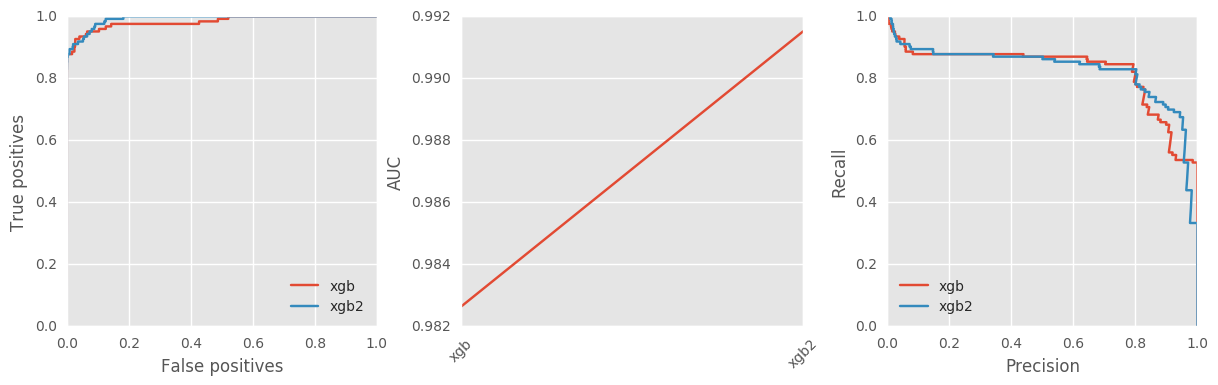

In [431]:
models = [{'name':'xgb', 'estimator': xgb, 'predictors':predictors},
         {'name':'xgb2', 'estimator': xgb2, 'predictors':predictors2}]
plot3(models, test)

This is a really quite big improvement on the AUC score, but can maybe be improved on slightly by re-tuning the parameters. Training on the full dataset takes too much time, so for convenience we use a smaller part of it.

In [505]:
#Use smaller training set for tuning xgb
df_xgb, _ = train_test_split(df, test_size=0.75, stratify=df['Class'], random_state=rs)
train_xgb, test_xgb = train_test_split(df_xgb, test_size=0.33, stratify=df_xgb['Class'], random_state=rs)

xgb3 = XGBClassifier(n_estimators=350, max_depth=4, min_child_weight=70, 
                    gamma=0.2, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.001, reg_lambda=0.1, seed=rs
                   )
xgb3.fit(train_xgb[predictors2], train_xgb['Class'], eval_metric='auc', sample_weight = get_weights(train_xgb['Class']), 
       eval_set=[(train_xgb[predictors2], train_xgb['Class']),(test_xgb[predictors2], test_xgb['Class'])],
          early_stopping_rounds=400, verbose=False)

auc_score(xgb3, test_xgb[predictors2], test_xgb['Class'])

0.97455536884836791

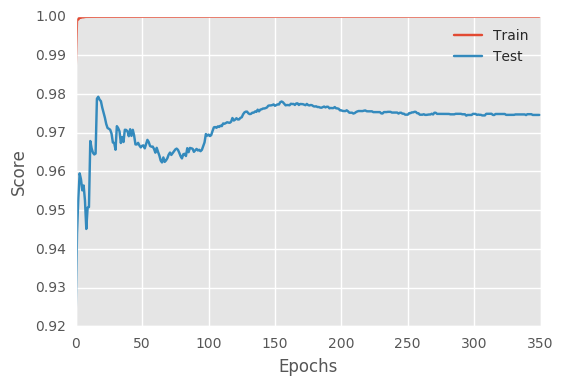

In [506]:
plot_xgb_epochs(xgb3)

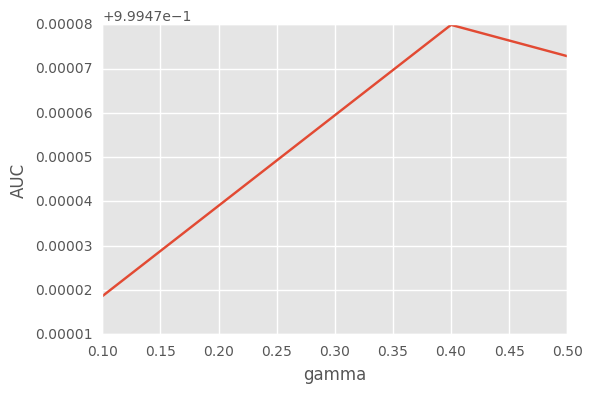

In [459]:
xgb3 = XGBClassifier(n_estimators=150, max_depth=3, min_child_weight=50, 
                    gamma=0.4, subsample=0.6, colsample_bytree=0.4, colsample_bylevel=0.5, 
                     reg_alpha=0.001, reg_lambda=0.1, seed=rs)

parameters = {'gamma':[0.1, 0.4, 0.5]}
# train_test_iterator = StratifiedKFold(n_splits=3, random_state=rs)
train_test_iterator = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=rs)

gs = GridSearchWrapper(xgb3, parameters, train_xgb[predictors2], train_xgb['Class'], cv=train_test_iterator, log=False)

In [460]:
xgb3 = XGBClassifier(n_estimators=1000, max_depth=3, min_child_weight=50, 
                    gamma=0.4, subsample=0.6, colsample_bytree=0.4, colsample_bylevel=0.5, 
                     reg_alpha=0.001, reg_lambda=0.1, seed=rs)

xgb3.fit(train[predictors2], train['Class'], eval_metric='auc', sample_weight = get_weights(train['Class']), 
       eval_set=[(train[predictors2], train['Class']),(test[predictors2], test['Class'])],
          early_stopping_rounds=200, verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=0.5, colsample_bytree=0.4,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=50, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.001, reg_lambda=0.1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

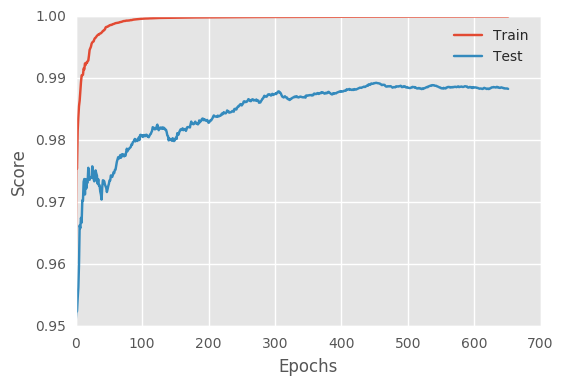

In [501]:
plot_xgb_epochs(xgb3)

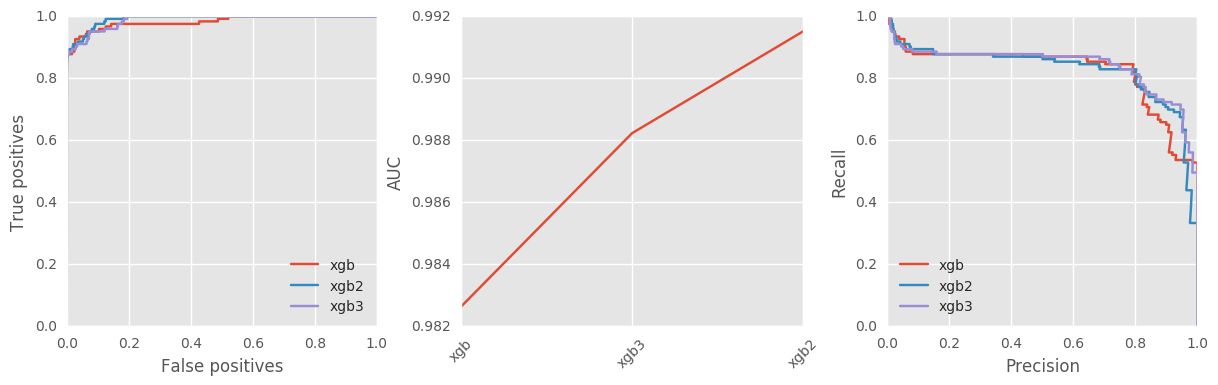

In [463]:
models = [{'name':'xgb', 'estimator': xgb, 'predictors':predictors},
         {'name':'xgb2', 'estimator': xgb2, 'predictors':predictors2},
         {'name':'xgb3', 'estimator': xgb3, 'predictors':predictors2}]
plot3(models, test)

# Automatic hyperparameter tuning

It is too cumbersome to manually tune the hyperparameters with the full data, and tuning with a small part of the data seems to yield worse results than our initial model. Let's try our hand at automatic hyperparameter tuning using scikit-optimize.

In [469]:
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [484]:

model = XGBClassifier(nthread=2, n_estimators=1000, max_depth=4, min_child_weight=70, 
                    gamma=0.2, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.001, reg_lambda=0.1, seed=rs
                   )

def objective(params):
    learning_rate, gamma, max_depth, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda = params
    
    model.set_params(learning_rate=learning_rate, 
                     gamma=gamma, 
                     max_depth=max_depth, 
                     min_child_weight=min_child_weight, 
                     subsample=subsample, 
                     colsample_bytree=colsample_bytree, 
                     reg_alpha=reg_alpha, 
                     reg_lambda=reg_lambda)
    
    model.fit(train[predictors2], train['Class'], eval_metric='auc', 
              eval_set=[(test[predictors2], test['Class'])], sample_weight=get_weights(train['Class']),
             early_stopping_rounds = 100, verbose=False)
    
    y_score = model.predict_proba(test[predictors2])[:,1]
    auc = roc_auc_score(test['Class'], y_score)
    
    return -auc

space  = [
          (10**-4, 10**0, "log-uniform"),   # learning_rate
          (0, 0.4),                         # gamma
          (2, 6),                         # max_depth
          (10, 100),                         # min_child_weight
          (0.5, 1.0),                         # subsample
          (0.5, 1.0),                         # colsample_bytree
          (10**-5, 10**2, "log-uniform"),                         # reg_alpha
          (10**-5, 10**2, "log-uniform")]                         # reg_lambda


# res_gp = gp_minimize( objective, space, n_calls=50, n_jobs=-1, random_state=0, x0 =[0.1, 0.2, 4, 70, 0.6, 0.6, 0.001, 0.1] )
res_gp3 = gp_minimize( objective, space, n_calls=50, n_jobs=2, random_state=0, x0 =res_gp2.x_iters, y0=res_gp2.func_vals )


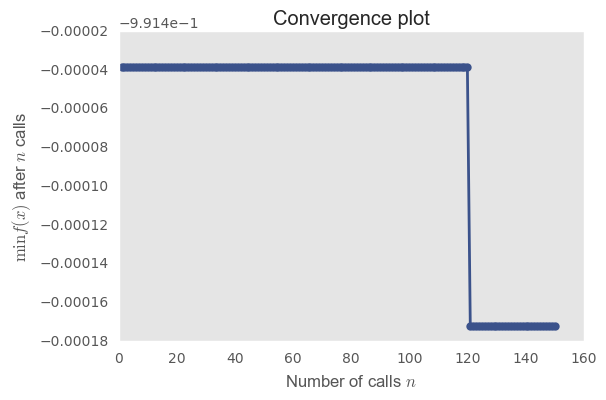

In [485]:
plot_convergence(res_gp3);

The Bayesian Search seems to have found one set of hyperparameters that seems to perform better than our manually selected one. Let's train the model fully with these and compare. 

In [489]:
res_gp3.x

[0.075082139819797139,
 0,
 2,
 95,
 0.79028876896564992,
 1.0,
 2.227499398351219,
 0.15826109042739245]

In [494]:
xgb_opt = XGBClassifier(nthread=2,n_estimators=1200, learning_rate=0.075082139819797139, max_depth=2, min_child_weight=95,
                    gamma=0, subsample=0.79028876896564992, colsample_bytree=1, reg_lambda=2.227499398351219, reg_alpha=0.15826109042739245, seed=rs)

xgb_opt.fit(train[predictors2], train['Class'], eval_metric='auc', sample_weight=get_weights(train['Class']),
           eval_set=[(test[predictors2], test['Class'])],early_stopping_rounds = 200, verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.07508213981979714, max_delta_step=0,
       max_depth=2, min_child_weight=95, missing=None, n_estimators=1200,
       nthread=2, objective='binary:logistic',
       reg_alpha=0.15826109042739245, reg_lambda=2.227499398351219,
       scale_pos_weight=1, seed=42, silent=True,
       subsample=0.7902887689656499)

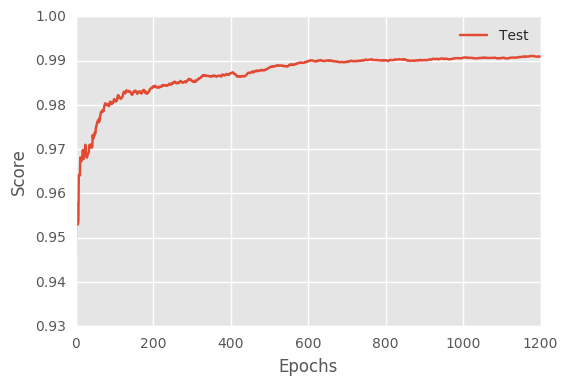

In [500]:
plot_xgb_epochs(xgb_opt)

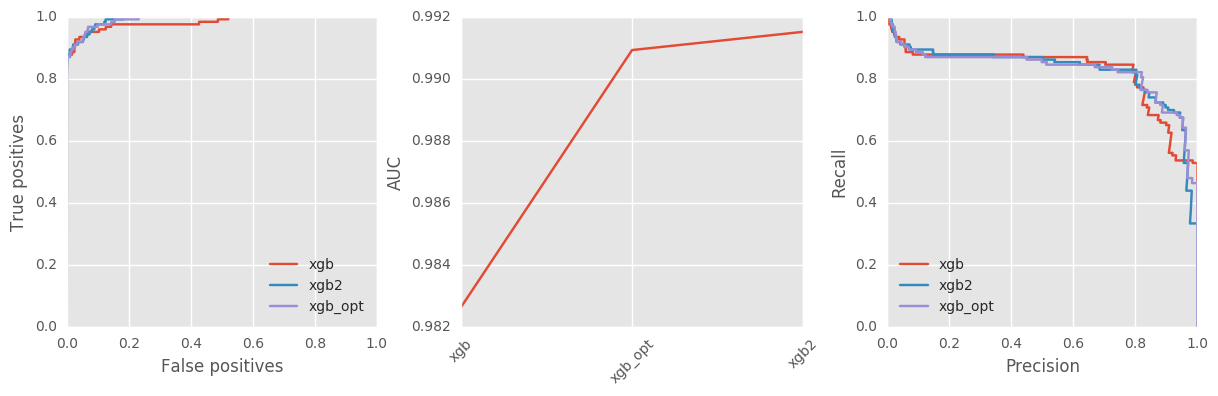

In [495]:
models = [{'name':'xgb', 'estimator': xgb, 'predictors':predictors},
         {'name':'xgb2', 'estimator': xgb2, 'predictors':predictors2},
         {'name':'xgb_opt', 'estimator': xgb_opt, 'predictors':predictors2}]
plot3(models, test)

It seems we weren't able to improve the final result with automatic parameter tuning in this case. This is due to the effort already spent on manually tuning the model, and probably a bit of luck. 